# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from itertools import product

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
home_path = os.getcwd()
CANCER_DATA_PATH = os.path.join(home_path, "hw2_data", "cancer.csv")
SPAM_DATA_PATH = os.path.join(home_path, "hw2_data", "spam.csv")

In [3]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pd.read_csv(path_to_csv)
    X, y = df.drop("label", axis=1), df.label
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    return read_cancer_dataset(path_to_csv)

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [5]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    df = X.copy()
    df["y"] = y
    train = df.sample(frac=ratio)
    test = df.loc[list(set(df.index)-set(train.index)), :]
    
    return train.drop("y", axis=1), train.y, test.drop("y", axis=1), test.y

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    labels = np.unique(y_true)
    df = pd.DataFrame(index=y_pred.index, columns=["y_pred", "y_true"])
    df.y_pred = y_pred
    df.y_true = y_true
    precision = [
        (df[df.y_pred == labels[i]]["y_true"] == labels[i]).mean() for i in range(len(labels))
    ]
    recall = [
        (df[df.y_true == labels[i]]["y_pred"] == labels[i]).mean() for i in range(len(labels))
    ]
    rescale = lambda x: 2*(x == labels[0]) - 1
    arr = df.y_pred.apply(rescale) * df.y_true.apply(rescale)
    accuracy = np.mean(arr == 1)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in tqdm(ks):
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        plt.xticks(range(1, max_k+1))
        plt.grid()
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    labels = y_train.value_counts().index
    positive_samples = sum(1 for y in y_test if y == labels[0])
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    metrics = []
    colors = []
    for k in tqdm(ks):
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test).values]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [labels[0 if p > w else 1] for p in p_pred]
            tpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == labels[0] and yt == labels[0]) / positive_samples
            )
            fpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == labels[0] and yt != labels[0]) / (len(y_test) - positive_samples)
            )
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
        y_test_bin = y_test == labels[0]
        metrics.append(roc_auc_score(y_test_bin, p_pred))
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.legend([f"ROC for {k}NN" for k in ks]+["Random"])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()
    df = pd.DataFrame(columns=["k", "auroc"])
    df.k = ks
    df.auroc = metrics
    print(df)

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [9]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.kdtree = None
    
    def fit(self, X, y):
        from scipy.spatial import KDTree
        self.X_train = X
        self.y_train = y
        self.kdtree = KDTree(X, leafsize=self.leaf_size)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        distances, idxs = self.kdtree.query(X, k=self.n_neighbors)
        labels_total = pd.DataFrame(self.y_train.value_counts())
        labels_total.columns = ["total"]
        y_pred = pd.DataFrame(index=X.index, columns=labels_total.index)
        i = 0
        for idx in idxs:            
            labels = pd.DataFrame(
                self.y_train.iloc[[idx] if self.n_neighbors==1 else idx].value_counts()
            )
            labels.columns = ["res"]
            labels = labels_total.join(labels, how="left").fillna(0)["res"]
            prob = (labels/self.n_neighbors).values
            y_pred.iloc[i, :] = prob
            i += 1
        return y_pred
        
    def predict(self, X):
        y_pred = self.predict_proba(X)
        return pd.Series(
            [y_pred.columns[i] for i in np.argmax(y_pred.values, axis=1)], index=y_pred.index
        )

Наконец, протестируем наш классификатор на различных наборах данных

In [10]:
def scale(X):
    return pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

100%|██████████| 30/30 [00:06<00:00,  4.75it/s]


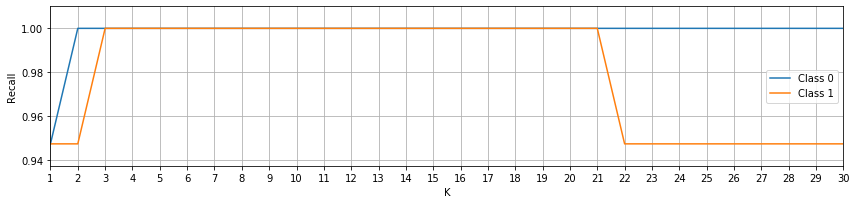

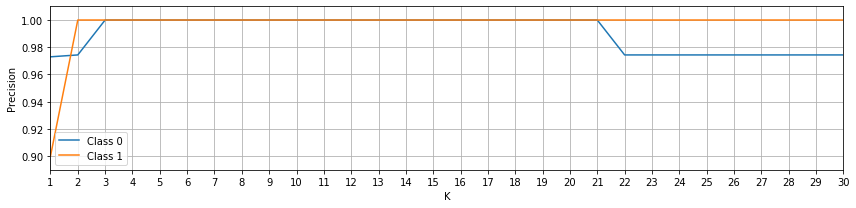

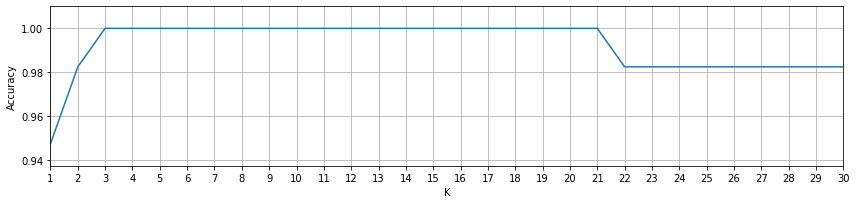

100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


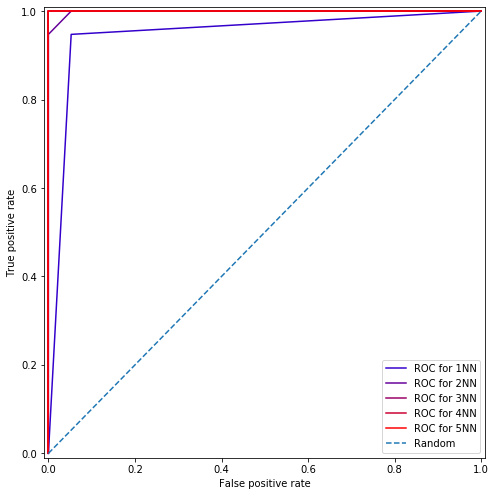

   k     auroc
0  1  0.947368
1  2  0.998615
2  3  1.000000
3  4  1.000000
4  5  1.000000


In [11]:
np.random.seed(19)
X_train, y_train, X_test, y_test = train_test_split(scale(X_cancer), y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=5)

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


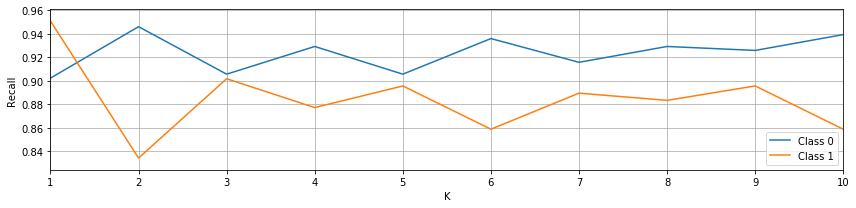

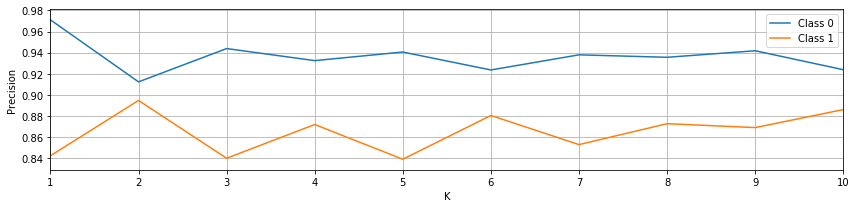

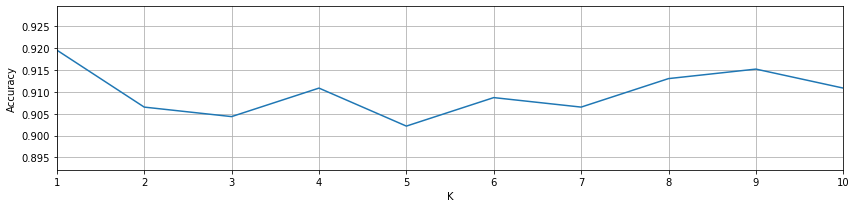

100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


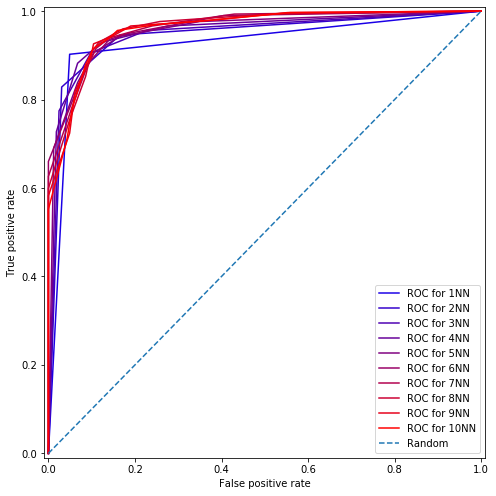

    k     auroc
0   1  0.926639
1   2  0.944331
2   3  0.947378
3   4  0.953306
4   5  0.954494
5   6  0.962467
6   7  0.963066
7   8  0.962601
8   9  0.961631
9  10  0.960815


In [12]:
np.random.seed(19)
X_train, y_train, X_test, y_test = train_test_split(scale(X_spam), y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=10)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

Для обеих задач ROC наиболее полно отражает способность моделей разделять классы, так она не зависит от выбора конкретного порогового значения вероятности.

Для первой задачи оптимальным числом соседей является 3, так как при данном значении качество по всем метрикам достигает максимума. Дальнешее увеличение k не может обеспечить прироста в качестве, но только увеличит вычислительную сложность расчетов.

Для второй задачи оптимальным числом соседей является 7, так как площадь под графиком ROC достигает максимума на этом значении.

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [13]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [14]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels)+1, 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.grid()
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.grid()
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

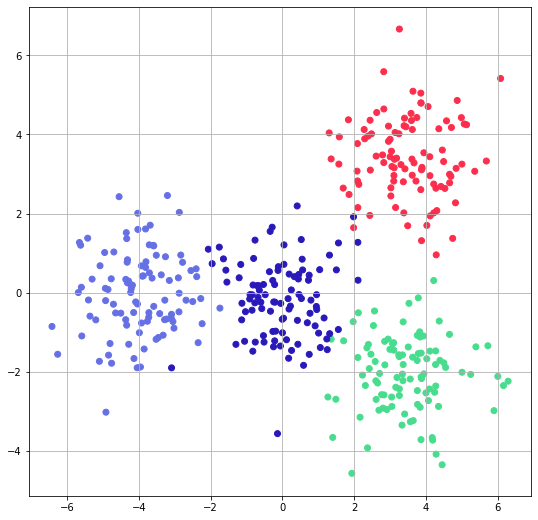

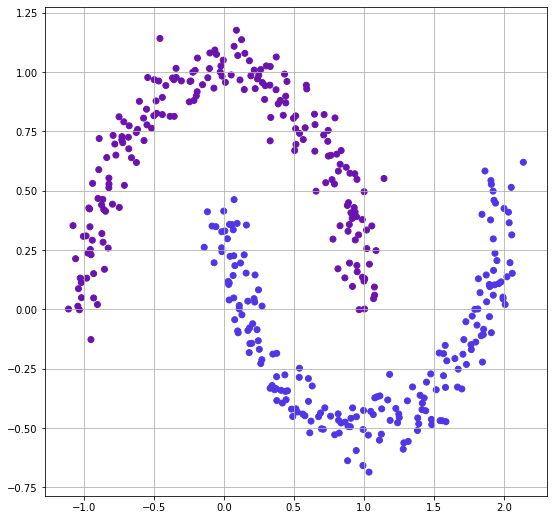

In [15]:
np.random.seed(19)
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [16]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        assert init in ["random", "sample", "k-means++"]
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        
    def fit(self, X, y=None):
        
        n, m = X.shape
        
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, m)
        elif self.init == "sample":
            centroids = pd.DataFrame(X).sample(n=self.n_clusters).values
        else:
            centroids = []
            probs = [1]*n
            for _ in range(self.n_clusters):
                centroids.append(pd.DataFrame(X).sample(n=1, weights=probs).values)
                dist = []
                for centroid in centroids:
                    dist.append(np.linalg.norm(X - centroid, ord=2, axis=1).reshape(n, 1))
                dist = np.max(np.concatenate(dist, axis=1), axis=1)**2
                probs = dist/sum(dist)

        df = pd.DataFrame(X)
        df["cluster"] = None
            
        for _ in range(self.max_iter):
            dist = []
            for centroid in centroids:
                dist.append(np.linalg.norm(X - centroid, ord=2, axis=1).reshape(n, 1))
            dist = np.concatenate(dist, axis=1)
            df.cluster = np.argmin(dist, axis=1)
            centroids = df.groupby("cluster").mean().values          

        self.centroids = centroids
    
    def predict(self, X):

        df = pd.DataFrame(X)
        df["cluster"] = None
        n, m = X.shape
        dist = []
        for centroid in self.centroids:
            dist.append(np.linalg.norm(X - centroid, ord=2, axis=1).reshape(n, 1))
        dist = np.concatenate(dist, axis=1)
        df.cluster = np.argmin(dist, axis=1)
        return df.cluster.values

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

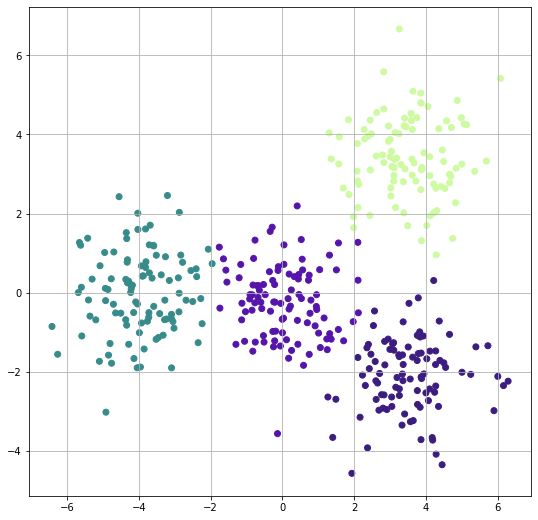

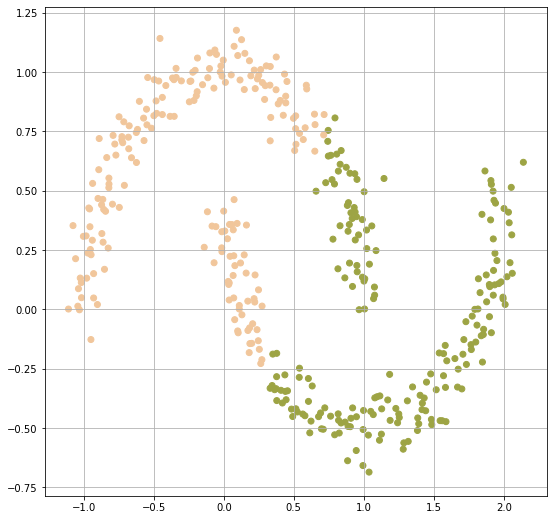

In [17]:
np.random.seed(19)
kmeans = KMeans(n_clusters=4, init="k-means++", max_iter=100)
kmeans.fit(X_1)
labels_km_1 = kmeans.predict(X_1)
visualize_clasters(X_1, labels_km_1)

kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=100)
kmeans.fit(X_2)
labels_km_2 = kmeans.predict(X_2)
visualize_clasters(X_2, labels_km_2)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [18]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        n, m = X.shape
        from sklearn.neighbors import KDTree
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        df = pd.DataFrame(X)
        df["type"] = "noise"
        df["cluster"] = 0
        neib = lambda idx: list(tree.query_radius(X[[idx],:], r=self.eps)[0])
        core = [idx for idx in range(n) if len(neib(idx))-1>=self.min_samples]
        noise = [idx for idx in range(n) if idx not in core]
        visited = []
        to_visit = []
        cluster_id = 0
        while set(core)-set(visited):
            cluster_id += 1
            to_visit.append(
                np.random.choice(list(set(core)-set(visited)))
            )
            while to_visit:
                idx = to_visit[0]
                df.loc[idx, "type"] = "core"
                df.loc[idx, "cluster"] = cluster_id
                to_visit.remove(idx)
                visited.append(idx)
                neighbors = list(tree.query_radius(X[[idx],:], r=self.eps)[0])
                neighbors.remove(idx)
                neighbors = [i for i in neighbors if i in core]
                to_visit = list((set(neighbors) - set(visited)) | set(to_visit))
                
        for idx in noise:
            neighbors = list(tree.query_radius(X[[idx],:], r=self.eps)[0])
            neib_cores_idxs = list(set(neighbors) & set(core))
            if neib_cores_idxs:
                df.loc[idx, "type"] = "border"
                bdf = df.loc[neib_cores_idxs, "cluster"]
                cluster_id = bdf[bdf != 0].value_counts().sort_values(ascending=False).index[0]
                df.loc[idx, "cluster"] = cluster_id

        return df.cluster.values

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

[0 1 2 3 4]


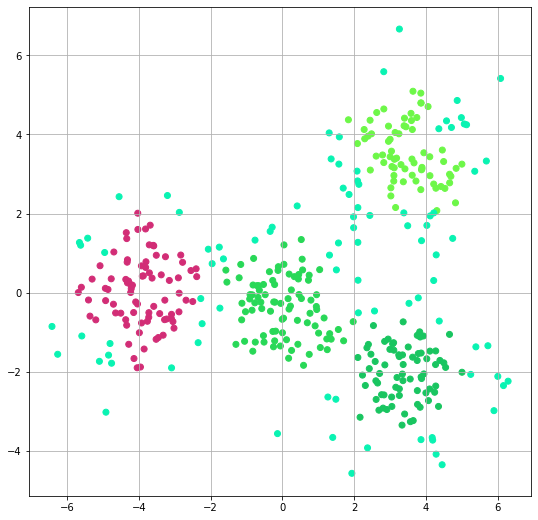

In [19]:
np.random.seed(21)
dbscan = DBScan(min_samples=7, eps=0.57)
labels_dbs_1 = dbscan.fit_predict(X_1)
print(np.unique(labels_dbs_1))
visualize_clasters(X_1, labels_dbs_1)

[1 2]


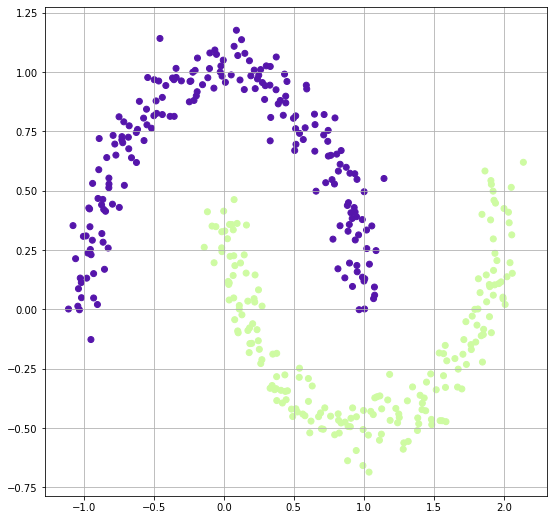

In [20]:
np.random.seed(19)
dbscan = DBScan(min_samples=3, eps=0.18)
labels_dbs_2 = dbscan.fit_predict(X_2)
print(np.unique(labels_dbs_2))
visualize_clasters(X_2, labels_dbs_2)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

О высоком качестве кластеризации свидетельствуют близкие к 0 значения Davies-Bouldin index и близкие к 1 значения Silhouette score

Судя по визуализации k-means лучше справился с первым датасетом, а DBSCAN - со вторым

In [21]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [22]:
res_df = pd.DataFrame(index=["DB Index", "Silhouette"], columns=["task_1", "task_2"])
res_df.loc["DB Index", "task_1"] = davies_bouldin_score(X_1, labels_km_1)
res_df.loc["DB Index", "task_2"] = davies_bouldin_score(X_2, labels_km_2)
res_df.loc["Silhouette", "task_1"] = silhouette_score(X_1, labels_km_1)
res_df.loc["Silhouette", "task_2"] = silhouette_score(X_2, labels_km_2)
print("Метрики качества кластеризации для k-means")
res_df

Метрики качества кластеризации для k-means


,task_1,task_2
DB Index,0.570406,0.786337
Silhouette,0.568375,0.486777


In [23]:
res_df = pd.DataFrame(index=["DB Index", "Silhouette"], columns=["task_1", "task_2"])
res_df.loc["DB Index", "task_1"] = davies_bouldin_score(X_1, labels_dbs_1)
res_df.loc["DB Index", "task_2"] = davies_bouldin_score(X_2, labels_dbs_2)
res_df.loc["Silhouette", "task_1"] = silhouette_score(X_1, labels_dbs_1)
res_df.loc["Silhouette", "task_2"] = silhouette_score(X_2, labels_dbs_2)
print("Метрики качества кластеризации для DBSCAN")
res_df

Метрики качества кластеризации для DBSCAN


,task_1,task_2
DB Index,2.00667,1.17393
Silhouette,0.370189,0.325056


Кажется, что для второго датасета выбранные метрики не вполне хорошо отображают наши интутивные представления о качественной кластеризации

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [24]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [25]:
# agg_clustering = AgglomertiveClustering(n_clusters=4)
# labels = agg_clustering.fit_predict(X_1)
# visualize_clasters(X_1, labels)

# agg_clustering = AgglomertiveClustering(n_clusters=2)
# labels = agg_clustering.fit_predict(X_2)
# visualize_clasters(X_2, labels)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [26]:
# YOUR_CODE